# Plotting Voronoi and Power diagrams

Some next level plotting comming up.

In [1]:
import numpy as np
from matplotlib import (pyplot as plt, collections, patches)
from scipy.spatial import ConvexHull

In [2]:
def all_edges(ch, valid):
    """List all edges in the convex hull by finding all combinations of
    neighbouring simplices."""
    nb = np.zeros(shape=(len(valid), 2*ch.ndim), dtype=int)
    nb[:,1::2] = ch.neighbors[valid]
    nb[:,0::2] = valid[:,None]
    return np.unique(np.sort(nb.reshape([-1, 2]), axis=1), axis=0)

def finite_edges(ch, valid):
    """Finite edges have both simplices listed as valid. This returns a
    tuple containing the edges and a mask telling which edges are finite
    and which aren't."""
    edges = all_edges(ch, valid)
    finite = np.isin(edges, valid).sum(axis=1) == 2
    return edges, finite

def edge_points(ch, edges):
    """Compute the dual vertices for all finite edges."""
    save = np.seterr(invalid = 'ignore', divide = 'ignore')
    pts = - ch.equations[:,:2] / ch.equations[:,2][:,None] / 2
    np.seterr(**save)
    return pts[edges]

def infinite_ray(ch, edge, valid):
    """Compute the dual ray for an edge with one point at infinity."""
    if edge[0] in valid and edge[1] not in valid:
        f0 = edge[0]
        f1 = edge[1]
    elif edge[1] in valid and edge[0] not in valid:
        f0 = edge[1]
        f1 = edge[0]
    else:
        raise ValueError("Edge should have precisely one simplex in valid.")
        
    v = [i for i in ch.simplices[f0] if i in ch.simplices[f1]]
    assert len(v) == 2
    v0 = ch.points[v[0]]
    v1 = ch.points[v[1]]
    centre = ch.points[ch.simplices[f0]].sum(axis=0) / 3
    if np.cross(v0 - centre, v1 - centre)[2] > 0:
        x = v1 - v0
    else:
        x = v0 - v1
    d = np.array([x[1], -x[0]])
    d /= np.sqrt(x[0]**2 + x[1]**2)
    return -ch.equations[f0, :2] / ch.equations[f0, 2] / 2, d

In [3]:
def plot_power_diagram(ch, valid, ax=None, inf_scale=10, linewidth=1.0, **kwargs):
    """Plot the power diagram."""
    edges, finite = finite_edges(ch, valid)
    m_edge_points = edge_points(ch, edges[finite])
    lc_grid = collections.LineCollection(m_edge_points, linewidth=linewidth, **kwargs)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    inf_rays = np.array([infinite_ray(ch, edge, valid) for edge in edges[~finite]])
    inf_edges = inf_rays.copy()
    inf_edges[:,1,:] += inf_edges[:,0,:]
    inf_dotted = collections.LineCollection(inf_edges, linestyle='dashed', zorder=10, color='black', linewidth=0.8)
    inf_arrows = [patches.FancyArrow(inf_rays[i,0,0], inf_rays[i,0,1], inf_rays[i,1,0]/10, inf_rays[i,1,1]/10,
                                     color='black', width=0.000, head_width=0.01)
                  for i in range(len(inf_rays))]
    inf_coll = collections.PatchCollection(inf_arrows, color='black', linewidth=linewidth)

    ax.add_collection(lc_grid)
    ax.add_collection(inf_dotted)
    ax.add_collection(inf_coll)

In [4]:
seed = 19
np.random.seed(seed)
N = 15
X = np.random.uniform(0, 1, (N, 2))
G = np.mgrid[-0.2:1.21:0.005,-0.2:1.21:0.005]

In [5]:
V1 = np.c_[X, (X**2).sum(axis=1)[:,None]]
ch1 = ConvexHull(V1)
valid1 = np.where(np.dot(ch1.equations[:,0:3], [0, 0, -1]) > 0.00001)[0]
Z1 = ((G.transpose([1,2,0])[:,:,None,:] - X[None,None,:,:])**2).sum(axis=3).min(axis=2)

In [6]:
m = 0.015
np.random.seed(10)
phi = m * np.random.rayleigh(1.0, N)

V2 = np.c_[X, ((X**2).sum(axis=1) + phi)[:,None]]
ch2 = ConvexHull(V2)
valid2 = np.where(np.dot(ch2.equations[:,0:3], [0, 0, -1]) > 0.00001)[0]
Z2 = (((G.transpose([1,2,0])[:,:,None,:] - X[None,None,:,:])**2).sum(axis=3) + phi[None, None, :]).min(axis=2)

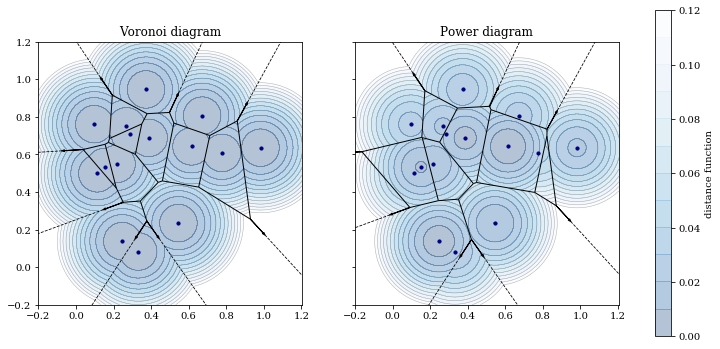

In [7]:
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(13, 6), subplot_kw={ 'aspect': 1 })

pos_ctrs = np.linspace(0, 0.12, 13)
ctrs = ax[0].contourf(G[0], G[1], Z1, pos_ctrs, alpha=0.3, cmap='Blues_r')
ax[0].contour(G[0], G[1], Z1, pos_ctrs, alpha=0.3, colors='black', linewidths=0.5)
ax[0].scatter(X[:,0], X[:,1], color='navy', s=10)
plot_power_diagram(ch1, valid1, ax[0], color='black', zorder=10, linewidth=1.0)

# pos_ctrs = np.linspace(0, 0.2, 15)
ax[1].contourf(G[0], G[1], Z2, pos_ctrs, alpha=0.3, cmap='Blues_r')
ax[1].contour(G[0], G[1], Z2, pos_ctrs, alpha=0.3, colors='black', linewidths=0.5)
ax[1].scatter(X[:,0], X[:,1], color='navy', s=10)
plot_power_diagram(ch2, valid2, ax[1], color='black', zorder=10, linewidth=1.0)

ax[0].set_ylim(-0.2, 1.2)
ax[1].set_ylim(-0.2, 1.2)

ax[0].set_title("Voronoi diagram")
ax[1].set_title("Power diagram")
fig.colorbar(ctrs, label='distance function', ax=ax)
fig.savefig("power-diagram.pdf", bbox_inches='tight')
plt.show()